<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/11_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Deployment

In [1]:
# torch 1.12+ ve torchvision 0.13+ üzeri olmalı
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version 1.12+ üzeri olmalı"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision 0.13+ üzeri olmalı"
    print(f"torch: {torch.__version__}")
    print(f"torchvision: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision en güncel sürümü ile yükleniyor...")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch: {torch.__version__}")
    print(f"torchvision: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Trochinfo Kurulumu
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulunamadı, yükleniyor...")
    !pip install -q torchinfo
    from torchinfo import summary

# Github'tan dosyalar indirilsin.
try:
    from Module_Files import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Module_Files adlı dosyalar
    print("[INFO] Github dosyaları indiriliyor.")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

    # MRDBOURKE'un Helper_Functions'ı
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # Helper_Functions by mrdbourke
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves

device = "cuda" if torch.cuda.is_available() else "cpu"

#VERİLERİ ALMA İŞLEMİ
# pizza, steak, sushi images from GitHub by mrdbourke
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# İndirilen verileri yerleştirme işlemi
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

[INFO] torch/torchvision en güncel sürümü ile yükleniyor...
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
[INFO] Github dosyaları indiriliyor.
Cloning into 'PyTorch_Education'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 562 (delta 27), reused 3 (delta 3), pack-reused 503 (from 2)
Receiving objects: 100% (562/562), 66.92 MiB | 35.09 MiB/s, done.
Resolving deltas: 100% (120/120), done.
data/pizza_steak_sushi Dosyası olusturuluyor
İndiriliyor...
Sıkıştırılmış dosyada çıkarılıyor...
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number 

##EffNetB2 ve ViT Modellerini Dağıtıma Hazırlama

###EffNetB2’yi Hazırlama

In [2]:
# 1. EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Modeli Hazırlama
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # weights="DEFAULT"

# 4. Temel Katmanları Model İçinde Dondurma
for param in effnetb2.parameters():
    param.requires_grad = False

# EffNetB2 Sınıf Başlıklarını Yazdıralım.
print(effnetb2.classifier)

# 5.Sınıf Başlıklarını Güncelleme
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), #dropout
    nn.Linear(in_features=1408, # girdiler
              out_features=3)) # çıktılarımız (Sınıf başlıkları)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 72.6MB/s]


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)


In [3]:
#EffnetB2 Modeli Oluşturma
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    # 1, 2, 3. EffNetB2 eğitilmiş weights, transforms ve model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Temel Katmanları Dondurma
    for param in model.parameters():
        param.requires_grad = False

    # 5. Tekrarlanabilirlik için sınıflandırma başlığını rastgele seed atma
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)
from torchinfo import summary

# EffNetB2 modelini yazdıralım.
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [4]:
#DataLoaders
from Module_Files import data_setup
from Module_Files import engine

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Loss fonksiyonu
loss_fn = torch.nn.CrossEntropyLoss()

# Seed Atıp Sonuçları Yazdırma
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


[INFO] Modelin Kaydedildiği Yer: models/09_effnetb2_pizza_steak_sushi_20_percent.pth


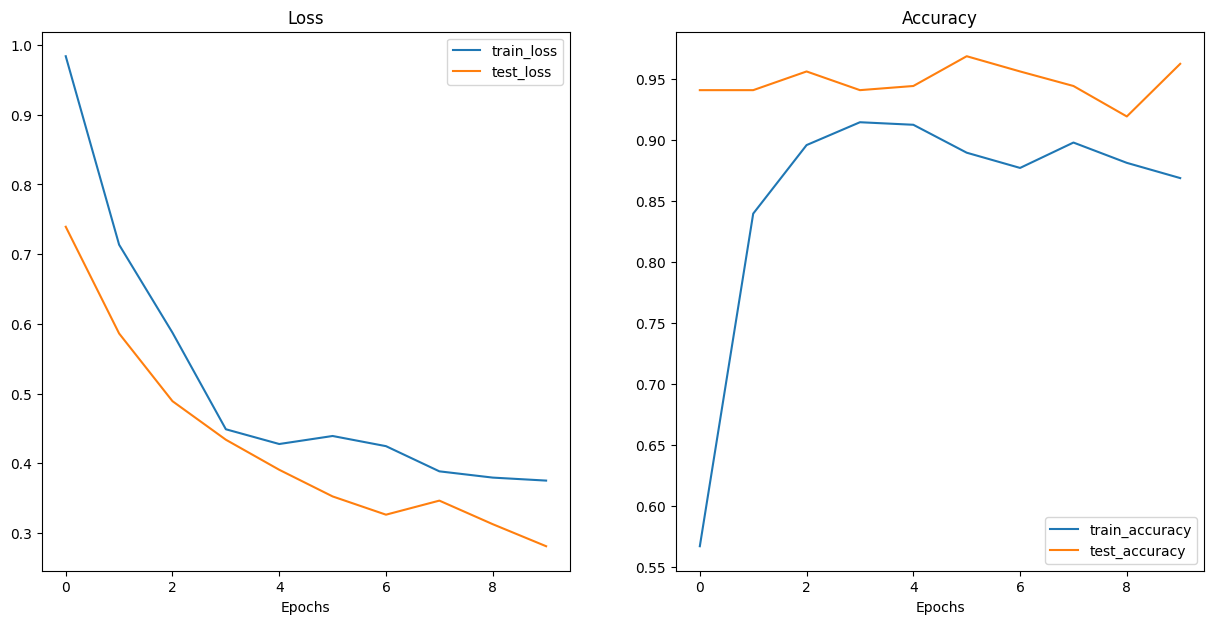

In [6]:
from helper_functions import plot_loss_curves
from Module_Files import utils

# Modeli Kaydetme
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_effnetb2_pizza_steak_sushi_20_percent.pth")

plot_loss_curves(effnetb2_results)

In [7]:
from pathlib import Path

# Baytlık veriyi megabayt yaptık.
pretrained_effnetb2_model_size = Path("models/09_effnetb2_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Eğitilmiş EffNetB2 Modeli Boyutu: {pretrained_effnetb2_model_size} MB")

# EffNetB2 Parametre Sayısı
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(effnetb2_total_params)

# EffNetB2 İstatistiksel Veri
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
print(effnetb2_stats)

Eğitilmiş EffNetB2 Modeli Boyutu: 29 MB
7705221
{'test_loss': 0.28108686208724976, 'test_acc': 0.9625, 'number_of_parameters': 7705221, 'model_size (MB)': 29}


###ViT-B/16 Modelini Hazırlama

In [9]:
# ViT Hazır Model
vit = torchvision.models.vit_b_16()
print(vit.heads)

#ViT Modelini Fonksiyon Olarak Tasarlayalım
def create_vit_model(num_classes:int=3,
                     seed:int=42):

    # ViT_B_16 eğtilmiş weights, transforms ve model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Dondurulmuş Katmanlar
    for param in model.parameters():
        param.requires_grad = False

    # Başlıklar hazır bir şekilde seed atma
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # orijinal modeldeki değer
                                          out_features=num_classes)) # 3 sınıf çıktımızın değeri

    return model, transforms


# ViT model ve transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

from torchinfo import summary

# ViT modelini yazdıralım.
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 80.7MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
[INFO] Modelin Kaydedildiği Yer: models/09_vit_pizza_steak_sushi_20_percent.pth
Eğitilmiş ViT Modeli Boyutu: 

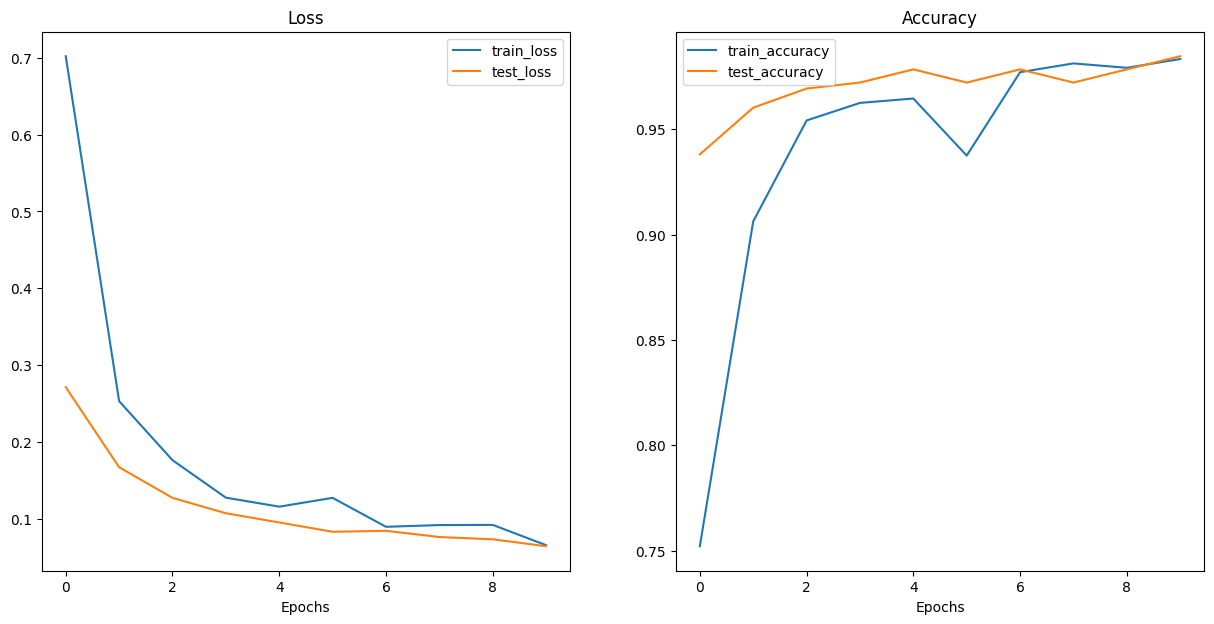

In [10]:
#ViT DataLoaders
from Module_Files import data_setup
from Module_Files import engine
from Module_Files import utils
from pathlib import Path
from helper_functions import plot_loss_curves

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Loss Fonksiyonu
loss_fn = torch.nn.CrossEntropyLoss()

# ViT model ve seeds
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

plot_loss_curves(vit_results)

# Modeli Kaydet
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_vit_pizza_steak_sushi_20_percent.pth")

# byt'ları Megabayt yapalım
pretrained_vit_model_size = Path("models/09_vit_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Eğitilmiş ViT Modeli Boyutu: {pretrained_vit_model_size} MB")

# ViT Parametre Sayısı
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
print(vit_total_params)

# ViT İstatistiklerini Yazdıralım
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

print(vit_stats)